In [1]:
from google.colab import files
uploaded = files.upload()

Saving tr_data.csv to tr_data.csv


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn.preprocessing as skl_pre
#import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

In [3]:
# Load dataset
df = pd.read_csv('tr_data.csv', na_values='?', dtype={'ID': str}).dropna().reset_index()

In [ ]:
df.describe()

,index,hour_of_day,day_of_week,month,holiday,weekday,summertime,temp,dew,humidity,precip,snow,snowdepth,windspeed,cloudcover,visibility
count,1600.00000,1600.00000,1600.000000,1600.000000,1600.000000,1600.000000,1600.00000,1600.000000,1600.000000,1600.000000,1600.000000,1600.0,1600.000000,1600.000000,1600.000000,1600.000000
mean,799.50000,11.37125,3.022500,6.468750,0.033125,0.710000,0.64375,15.210313,7.750750,63.927844,0.122042,0.0,0.042713,13.082500,64.322375,15.344125
std,462.02453,6.94837,2.012965,3.454741,0.179019,0.453904,0.47904,9.264785,10.026459,19.079419,0.920600,0.0,0.421198,7.756652,32.748869,2.323737
min,0.00000,0.00000,0.000000,1.000000,0.000000,0.000000,0.00000,-9.100000,-18.400000,15.850000,0.000000,0.0,0.000000,0.000000,0.000000,0.100000
25%,399.75000,5.00000,1.000000,3.000000,0.000000,0.000000,0.00000,7.700000,-0.800000,47.845000,0.000000,0.0,0.000000,7.500000,28.800000,16.000000
50%,799.50000,12.00000,3.000000,6.000000,0.000000,1.000000,1.00000,15.500000,8.300000,65.175000,0.000000,0.0,0.000000,12.300000,79.300000,16.000000
75%,1199.25000,17.00000,5.000000,9.000000,0.000000,1.000000,1.00000,23.200000,16.800000,79.955000,0.000000,0.0,0.000000,17.600000,92.800000,16.000000
max,1599.00000,23.00000,6.000000,12.000000,1.000000,1.000000,1.00000,35.600000,24.300000,99.890000,25.871000,0.0,6.710000,43.800000,100.000000,16.000000


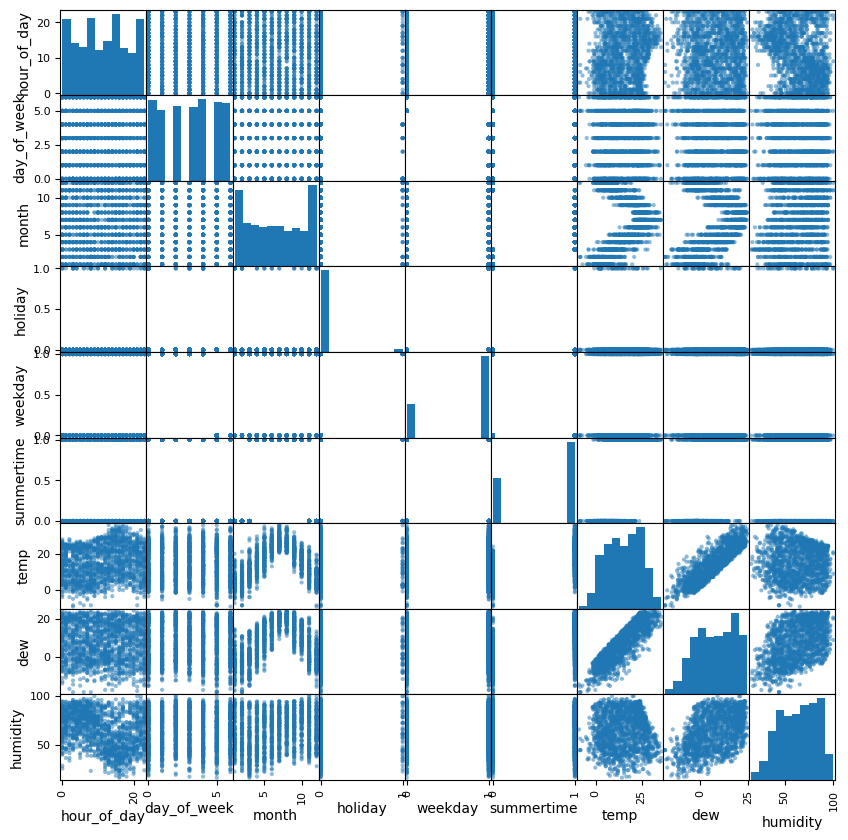

In [4]:
#scatterplot of the variables V1-V9
pd.plotting.scatter_matrix(df.iloc[:,1:10], figsize=(10,10))
plt.show()

In [6]:
# Step 3. Handling Categorical Data

from sklearn.preprocessing import LabelEncoder

# Encode the target variable
label_encoder = LabelEncoder()
df['increase_stock'] = label_encoder.fit_transform(df['increase_stock'])

# Check the mapping of the categories to numbers
label_mapping = dict(zip(label_encoder.classes_,label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

{'high_bike_demand': 0, 'low_bike_demand': 1}


In [7]:
X = df.drop(columns = ['increase_stock'])  # Drop 'ID' and target column for features
y = df['increase_stock']                       # Target column

print(X.shape,y.shape)

(1600, 16) (1600,)


In [23]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing set
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1280, 16) (320, 16) (1280,) (320,)


In [27]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Check the class distribution
print("Class distribution after Random Oversampling:", pd.Series(y_train_ros).value_counts())

Class distribution after Random Oversampling: increase_stock
1    1042
0    1042
Name: count, dtype: int64


In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
model = LogisticRegression(solver = 'liblinear', max_iter=1000, random_state=42)

#model = LogisticRegression(solver = 'lbfgs', max_iter=1000, random_state=42)

model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

err = np.mean(y_pred != y_test)
print("Error", err)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Error 0.1625
Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.48      0.44      0.46        50
           1       0.90      0.91      0.90       270

    accuracy                           0.84       320
   macro avg       0.69      0.68      0.68       320
weighted avg       0.83      0.84      0.83       320

[[ 22  28]
 [ 24 246]]


In [32]:
# Define parameter distributions for random search
param_distributions = {
    "C": loguniform(0.001, 100),  # Log-uniform distribution for regularization strength
    "solver": ["liblinear", "lbfgs"],  # Solvers to test
    "class_weight": [None, "balanced"],  # Handle class imbalance
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=1000),
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    cv=5,  # 5-fold cross-validation
    scoring="accuracy",
    random_state=42,
    n_jobs=-1,
)

# Perform the random search
random_search.fit(X_train_scaled, y_train)

# Display the best parameters and the corresponding training accuracy
best_params_random = random_search.best_params_
best_score_random = random_search.best_score_

print("Best Parameters (Random Search):", best_params_random)
print("Best Cross-Validation Accuracy (Random Search):", best_score_random)


Best Parameters (Random Search): {'C': 0.061991000078022655, 'class_weight': None, 'solver': 'lbfgs'}
Best Cross-Validation Accuracy (Random Search): 0.85
